In [ ]:
import json
from collections import Counter, defaultdict

# 文件路径
file_path = "/home/wyp/project/ForestLLM/outputs/article/qwen_article_output.json"
# "/home/wyp/project/ForestLLM/outputs/0113/qwen_web_output.json"


# 查找重复 ID 的函数
def find_duplicate_ids_with_consistency(file_path):
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            data = json.load(file)

        # 提取所有的 ID 和对应数据
        id_map = defaultdict(list)
        for entry in data:
            if "id" in entry:
                id_map[entry["id"]].append(entry)

        # 统计每个 ID 的出现次数
        duplicates = {
            id_: entries for id_, entries in id_map.items() if len(entries) > 1
        }
        duplicate_count = len(duplicates)

        # 检查每组重复 ID 数据是否完全一致
        consistency_results = {}
        for id_, entries in duplicates.items():
            # 使用第一条数据作为参考，逐条比对
            reference_entry = json.dumps(entries[0], sort_keys=True)
            all_consistent = all(
                json.dumps(entry, sort_keys=True) == reference_entry
                for entry in entries
            )
            consistency_results[id_] = {
                "count": len(entries),
                "consistent": all_consistent,
            }

        return consistency_results, duplicate_count
    except Exception as e:
        return str(e), 0


# 执行检查
consistency_results, duplicate_count = find_duplicate_ids_with_consistency(file_path)

# 输出结果
print(f"重复的 ID 总数: {duplicate_count}")
print("重复的 ID 检查结果:")
for id_, result in consistency_results.items():
    status = "一致" if result["consistent"] else "不一致"
    print(f"- ID: {id_}, 出现次数: {result['count']}, 数据是否一致: {status}")
print(f"重复的 ID 总数: {duplicate_count}")

In [ ]:
15533 + 1856

In [ ]:
import json

def convert_jsonl_to_readable(input_file, output_file):
    """
    读取 JSONL 文件并转换 Unicode 转义字符，使其显示为可读的中文
    """
    with open(input_file, "r", encoding="utf-8") as f_in, open(output_file, "w", encoding="utf-8") as f_out:
        for line in f_in:
            data = json.loads(line)  # 解析 JSON 行
            readable_json = json.dumps(data, ensure_ascii=False)  # 转换回可读的中文
            f_out.write(readable_json + "\n")  # 写入新文件

    print(f"转换完成，已保存到 {output_file}")

# 示例调用
convert_jsonl_to_readable("/home/wyp/project/ForestLLM/data_sft/train_multiple_choice.jsonl", "/home/wyp/project/ForestLLM/data_sft/train_multiple_choice_readable.jsonl")


In [ ]:
import json

def split_mixed_jsonl(input_file, train_output_file, eval_output_file, batch_size=1000):
    """
    将混合的 JSONL 文件拆分成训练数据 (train) 和 评测数据 (eval)
    """
    train_data = []
    eval_data = []

    # 读取原始 JSONL 文件
    with open(input_file, "r", encoding="utf-8") as f:
        for line in f:
            try:
                data = json.loads(line.strip())  # 解析 JSON
                if "messages" in data:  # **训练数据**
                    train_data.append(data)
                elif "history" in data:  # **评测数据**
                    eval_data.append(data)
                else:
                    print(f"⚠️ 未知数据格式，跳过：{data}")  # 遇到无法解析的数据，跳过
            except json.JSONDecodeError:
                print(f"❌ JSON 解析失败，跳过：{line.strip()}")

            # **批量写入，减少 I/O 操作**
            if len(train_data) >= batch_size:
                with open(train_output_file, "a", encoding="utf-8") as train_f:
                    for entry in train_data:
                        train_f.write(json.dumps(entry, ensure_ascii=False) + "\n")
                train_data = []

            if len(eval_data) >= batch_size:
                with open(eval_output_file, "a", encoding="utf-8") as eval_f:
                    for entry in eval_data:
                        eval_f.write(json.dumps(entry, ensure_ascii=False) + "\n")
                eval_data = []

    # **写入剩余数据**
    if train_data:
        with open(train_output_file, "a", encoding="utf-8") as train_f:
            for entry in train_data:
                train_f.write(json.dumps(entry, ensure_ascii=False) + "\n")

    if eval_data:
        with open(eval_output_file, "a", encoding="utf-8") as eval_f:
            for entry in eval_data:
                eval_f.write(json.dumps(entry, ensure_ascii=False) + "\n")

    print(f"✅ 训练数据已保存到 {train_output_file}")
    print(f"✅ 评测数据已保存到 {eval_output_file}")

# 示例调用
split_mixed_jsonl("/home/wyp/project/ForestLLM/data_sft/eval_general_qa_readable.jsonl", "/home/wyp/project/ForestLLM/data_sft/train_general_qa.jsonl", "/home/wyp/project/ForestLLM/data_sft/eval_general_qa.jsonl")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 数据提取自表格
benchmarks = [
    "MMLU", "MMLU-Redux", "MMLU-Pro", "DROP", "IF-Eval",
    "GPOA Diamond", "SimpleQA", "FRAMES", "AlpacaEval2.0", "ArenaHard",
    "LiveCodeBench", "Codeforces", "SWE Verified", "Aider-Polyglot",
    "AIME 2024", "MATH-500", "CNMO 2024",
    "CLUEWSC", "C-Eval", "C-SimpleQA"
]

models = ["Claude-3.5-Sonnet", "GPT-4o", "DeepSeek V3", "OpenAI o1-mini", "OpenAI o1-1217", "DeepSeek R1"]

data = np.array([
    [88.3, 87.2, 88.5, 85.2, 91.8, 90.8],  # MMLU
    [88.9, 88.0, 89.1, 86.7, 0, 92.9],  # MMLU-Redux
    [78.0, 72.6, 75.9, 80.3, 0, 84.0],  # MMLU-Pro
    [88.3, 83.7, 91.6, 83.9, 90.2, 92.2],  # DROP
    [86.5, 84.3, 86.1, 84.8, 0, 83.3],  # IF-Eval
    [65.0, 49.9, 59.1, 60.0, 75.7, 71.5],  # GPOA Diamond
    [28.4, 38.2, 24.9, 7.0, 47.0, 30.1],  # SimpleQA
    [72.5, 80.5, 73.3, 76.9, 0, 82.5],  # FRAMES
    [52.0, 51.1, 70.0, 57.8, 0, 87.6],  # AlpacaEval2.0
    [85.2, 80.4, 85.5, 92.0, 0, 92.3],  # ArenaHard
    [38.9, 32.9, 36.0, 53.8, 63.4, 65.9],  # LiveCodeBench
    [20.3, 23.6, 58.7, 93.4, 96.6, 96.3],  # Codeforces
    [50.8, 38.8, 42.0, 41.6, 48.9, 49.2],  # SWE Verified
    [45.3, 16.0, 49.6, 32.9, 61.7, 53.3],  # Aider-Polyglot
    [16.0, 9.3, 39.2, 63.6, 79.2, 79.8],   # AIME 2024
    [78.3, 74.6, 90.2, 90.0, 96.4, 97.3],  # MATH-500
    [13.1, 10.8, 43.2, 67.6, 0, 78.8],  # CNMO 2024
    [85.4, 87.9, 90.9, 89.9, 0, 92.8],  # CLUEWSC
    [76.7, 76.0, 86.5, 68.9, 0, 91.8],  # C-Eval
    [55.4, 58.7, 68.0, 40.3, 0, 63.7]   # C-SimpleQA
])

# 创建DataFrame
df = pd.DataFrame(data, index=benchmarks, columns=models)

# 绘制多个柱状图
num_benchmarks = len(benchmarks)
num_models = len(models)
x = np.arange(num_benchmarks)

# 设置颜色
colors = ["#7ea8be", "#4a6fa5", "#1f4e79", "#7ea8be", "#4a6fa5", "#1f4e79"]

plt.figure(figsize=(12, 8))

for i in range(num_models):
    plt.bar(x + i * 0.12, df.iloc[:, i], width=0.12, label=models[i], color=colors[i])

plt.xticks(x + 0.3, benchmarks, rotation=90)
plt.ylabel("Score (%)")
plt.title("Benchmark Comparison Across AI Models")
plt.legend()
plt.tight_layout()

# 显示图表
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 数据提取自表格
benchmarks = [
    "MMLU", "MMLU-Redux", "MMLU-Pro", "DROP", "IF-Eval",
    "GPOA Diamond", "SimpleQA", "FRAMES", "AlpacaEval2.0", "ArenaHard",
    "LiveCodeBench", "Codeforces", "SWE Verified", "Aider-Polyglot",
    "AIME 2024", "MATH-500", "CNMO 2024",
    "CLUEWSC", "C-Eval", "C-SimpleQA"
]

models = ["Claude-3.5-Sonnet", "GPT-4o", "DeepSeek V3", "OpenAI o1-mini", "OpenAI o1-1217", "DeepSeek R1"]

data = np.array([
    [88.3, 87.2, 88.5, 85.2, 91.8, 90.8],  # MMLU
    [88.9, 88.0, 89.1, 86.7, 0, 92.9],  # MMLU-Redux
    [78.0, 72.6, 75.9, 80.3, 0, 84.0],  # MMLU-Pro
    [88.3, 83.7, 91.6, 83.9, 90.2, 92.2],  # DROP
    [86.5, 84.3, 86.1, 84.8, 0, 83.3],  # IF-Eval
    [65.0, 49.9, 59.1, 60.0, 75.7, 71.5],  # GPOA Diamond
    [28.4, 38.2, 24.9, 7.0, 47.0, 30.1],  # SimpleQA
    [72.5, 80.5, 73.3, 76.9, 0, 82.5],  # FRAMES
    [52.0, 51.1, 70.0, 57.8, 0, 87.6],  # AlpacaEval2.0
    [85.2, 80.4, 85.5, 92.0, 0, 92.3],  # ArenaHard
    [38.9, 32.9, 36.0, 53.8, 63.4, 65.9],  # LiveCodeBench
    [20.3, 23.6, 58.7, 93.4, 96.6, 96.3],  # Codeforces
    [50.8, 38.8, 42.0, 41.6, 48.9, 49.2],  # SWE Verified
    [45.3, 16.0, 49.6, 32.9, 61.7, 53.3],  # Aider-Polyglot
    [16.0, 9.3, 39.2, 63.6, 79.2, 79.8],   # AIME 2024
    [78.3, 74.6, 90.2, 90.0, 96.4, 97.3],  # MATH-500
    [13.1, 10.8, 43.2, 67.6, 0, 78.8],  # CNMO 2024
    [85.4, 87.9, 90.9, 89.9, 0, 92.8],  # CLUEWSC
    [76.7, 76.0, 86.5, 68.9, 0, 91.8],  # C-Eval
    [55.4, 58.7, 68.0, 40.3, 0, 63.7]   # C-SimpleQA
])

# 创建DataFrame
df = pd.DataFrame(data, index=benchmarks, columns=models)

# 绘制多个柱状图
num_benchmarks = len(benchmarks)
num_models = len(models)
x = np.arange(num_benchmarks)

# 设置颜色
colors = ["#7ea8be", "#4a6fa5", "#1f4e79", "#7ea8be", "#4a6fa5", "#FFA500"]

# 调整图表尺寸
plt.figure(figsize=(18, 12))  # 增大图表尺寸

for i in range(num_models):
    plt.bar(x + i * 0.12, df.iloc[:, i], width=0.12, label=models[i], color=colors[i])

plt.xticks(x + 0.3, benchmarks, rotation=90, fontsize=12)  # 调整 x 轴字体大小
plt.yticks(fontsize=12)  # 调整 y 轴字体大小
plt.ylabel("Score (%)", fontsize=14)  # 调整 y 轴标签字体
plt.title("Benchmark Comparison Across AI Models", fontsize=18)  # 增大标题字体
plt.legend(fontsize=12)  # 增大图例字体
plt.tight_layout()

# 仅提供代码，不绘制图表


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 数据提取自表格
benchmarks = [
    "MMLU", "MMLU-Redux", "MMLU-Pro", "DROP", "IF-Eval",
    "GPOA Diamond", "SimpleQA", "FRAMES", "AlpacaEval2.0", "ArenaHard",
    "LiveCodeBench", "Codeforces", "SWE Verified", "Aider-Polyglot",
    "AIME 2024", "MATH-500", "CNMO 2024",
    "CLUEWSC", "C-Eval", "C-SimpleQA"
]

models = ["Claude-3.5-Sonnet", "GPT-4o", "DeepSeek V3", "OpenAI o1-mini", "OpenAI o1-1217", "DeepSeek R1"]

data = np.array([
    [88.3, 87.2, 88.5, 85.2, 91.8, 90.8],  # MMLU
    [88.9, 88.0, 89.1, 86.7, 0, 92.9],  # MMLU-Redux
    [78.0, 72.6, 75.9, 80.3, 0, 84.0],  # MMLU-Pro
    [88.3, 83.7, 91.6, 83.9, 90.2, 92.2],  # DROP
    [86.5, 84.3, 86.1, 84.8, 0, 83.3],  # IF-Eval
    [65.0, 49.9, 59.1, 60.0, 75.7, 71.5],  # GPOA Diamond
    [28.4, 38.2, 24.9, 7.0, 47.0, 30.1],  # SimpleQA
    [72.5, 80.5, 73.3, 76.9, 0, 82.5],  # FRAMES
    [52.0, 51.1, 70.0, 57.8, 0, 87.6],  # AlpacaEval2.0
    [85.2, 80.4, 85.5, 92.0, 0, 92.3],  # ArenaHard
    [38.9, 32.9, 36.0, 53.8, 63.4, 65.9],  # LiveCodeBench
    [20.3, 23.6, 58.7, 93.4, 96.6, 96.3],  # Codeforces
    [50.8, 38.8, 42.0, 41.6, 48.9, 49.2],  # SWE Verified
    [45.3, 16.0, 49.6, 32.9, 61.7, 53.3],  # Aider-Polyglot
    [16.0, 9.3, 39.2, 63.6, 79.2, 79.8],   # AIME 2024
    [78.3, 74.6, 90.2, 90.0, 96.4, 97.3],  # MATH-500
    [13.1, 10.8, 43.2, 67.6, 0, 78.8],  # CNMO 2024
    [85.4, 87.9, 90.9, 89.9, 0, 92.8],  # CLUEWSC
    [76.7, 76.0, 86.5, 68.9, 0, 91.8],  # C-Eval
    [55.4, 58.7, 68.0, 40.3, 0, 63.7]   # C-SimpleQA
])

# 创建DataFrame
df = pd.DataFrame(data, index=benchmarks, columns=models)

# 逐个基准测试绘制单独的柱状图
for i, benchmark in enumerate(benchmarks):
    plt.figure(figsize=(6, 4))  # 设置单个图表大小
    
    # 获取当前基准测试的数据
    scores = df.iloc[i, :]
    
    # 颜色风格（淡紫色 & 深紫色），最高分用深紫色，其余用淡紫色
    # colors = ["#A7A2FF" if score < max(scores) else "#4A3DA3" for score in scores]
    colors = ["#A7A2FF", "#A7A2FF", "#A7A2FF", "#A7A2FF", "#A7A2FF", "#4A3DA3"]
    # 绘制柱状图
    bars = plt.bar(models, scores, color=colors)

    # 在柱状图上方标注数值
    for bar, score in zip(bars, scores):
        if score == 0:
            pass
        else:
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{score:.1f}%',
                    ha='center', fontsize=8, fontweight='bold')

    # 图表标题
    plt.title(benchmark, fontsize=12)

    # y 轴标签
    plt.ylabel("Score (%)", fontsize=8)
    
    # 隐藏 x 轴标签，仅展示模型名
    plt.xticks(rotation=20, ha='right', fontsize=8)

    # 调整布局
    plt.tight_layout()

    # 显示图表
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 数据提取自表格
benchmarks = [
    "MMLU", "MMLU-Redux", "MMLU-Pro", "DROP", "IF-Eval",
    "GPOA Diamond", "SimpleQA", "FRAMES", "AlpacaEval2.0", "ArenaHard",
    "LiveCodeBench", "Codeforces", "SWE Verified", "Aider-Polyglot",
    "AIME 2024", "MATH-500", "CNMO 2024",
    "CLUEWSC", "C-Eval", "C-SimpleQA"
]

models = ["Claude-3.5-Sonnet", "GPT-4o", "DeepSeek V3", "OpenAI o1-mini", "OpenAI o1-1217", "DeepSeek R1"]

data = np.array([
    [88.3, 87.2, 88.5, 85.2, 91.8, 90.8],  # MMLU
    [88.9, 88.0, 89.1, 86.7, 0, 92.9],  # MMLU-Redux
    [78.0, 72.6, 75.9, 80.3, 0, 84.0],  # MMLU-Pro
    [88.3, 83.7, 91.6, 83.9, 90.2, 92.2],  # DROP
    [86.5, 84.3, 86.1, 84.8, 0, 83.3],  # IF-Eval
    [65.0, 49.9, 59.1, 60.0, 75.7, 71.5],  # GPOA Diamond
    [28.4, 38.2, 24.9, 7.0, 47.0, 30.1],  # SimpleQA
    [72.5, 80.5, 73.3, 76.9, 0, 82.5],  # FRAMES
    [52.0, 51.1, 70.0, 57.8, 0, 87.6],  # AlpacaEval2.0
    [85.2, 80.4, 85.5, 92.0, 0, 92.3],  # ArenaHard
    [38.9, 32.9, 36.0, 53.8, 63.4, 65.9],  # LiveCodeBench
    [20.3, 23.6, 58.7, 93.4, 96.6, 96.3],  # Codeforces
    [50.8, 38.8, 42.0, 41.6, 48.9, 49.2],  # SWE Verified
    [45.3, 16.0, 49.6, 32.9, 61.7, 53.3],  # Aider-Polyglot
    [16.0, 9.3, 39.2, 63.6, 79.2, 79.8],   # AIME 2024
    [78.3, 74.6, 90.2, 90.0, 96.4, 97.3],  # MATH-500
    [13.1, 10.8, 43.2, 67.6, 0, 78.8],  # CNMO 2024
    [85.4, 87.9, 90.9, 89.9, 0, 92.8],  # CLUEWSC
    [76.7, 76.0, 86.5, 68.9, 0, 91.8],  # C-Eval
    [55.4, 58.7, 68.0, 40.3, 0, 63.7]   # C-SimpleQA
])

# 创建DataFrame
df = pd.DataFrame(data, index=benchmarks, columns=models)

# 设置子图布局
num_rows = 5  # 设置5行
num_cols = 4  # 设置4列（最多20个基准测试）
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
fig.suptitle("Benchmark Comparison Across AI Models", fontsize=20)

# 逐个基准测试绘制子图
for i, (benchmark, ax) in enumerate(zip(benchmarks, axes.flatten())):
    scores = df.iloc[i, :]
    
    # 颜色风格（淡紫色 & 深紫色），最高分用深紫色，其余用淡紫色
    colors = ["#A7A2FF" if score < max(scores) else "#4A3DA3" for score in scores]

    # 绘制柱状图
    bars = ax.bar(models, scores, color=colors)

    # 在柱状图上方标注数值
    for bar, score in zip(bars, scores):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{score:.1f}%',
                ha='center', fontsize=10, fontweight='bold')

    # 设置子图标题
    ax.set_title(benchmark, fontsize=12)
    
    # 隐藏 x 轴标签，仅展示模型名
    ax.set_xticklabels(models, rotation=20, ha='right', fontsize=8)
    ax.set_ylim(0, 100)  # 统一 y 轴范围

# 调整布局
plt.tight_layout(rect=[0, 0, 1, 0.95])

# 显示图表
plt.show()


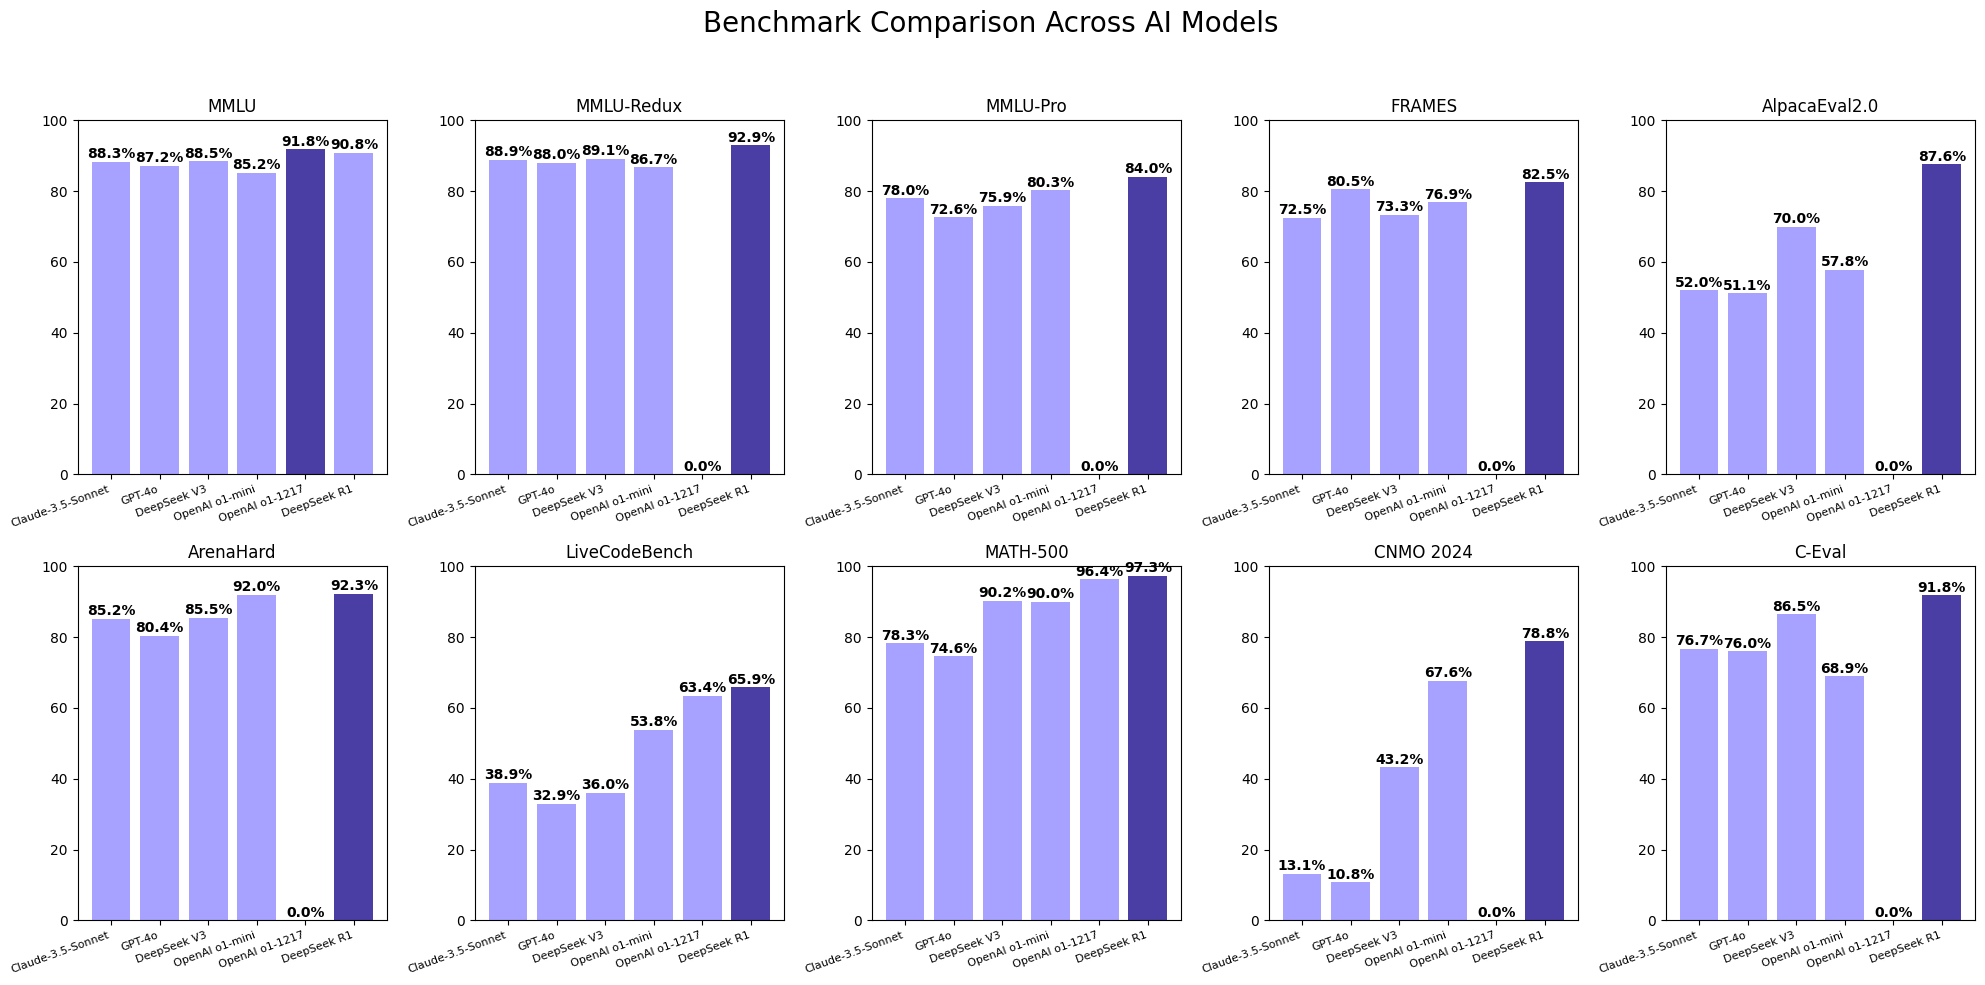

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 修正后的基准列表（与 data 行数匹配）
benchmarks = [
    "MMLU", "MMLU-Redux", "MMLU-Pro", "FRAMES", "AlpacaEval2.0",
    "ArenaHard", "LiveCodeBench", "MATH-500", "CNMO 2024", "C-Eval"
]

# 模型列表
models = ["Claude-3.5-Sonnet", "GPT-4o", "DeepSeek V3", "OpenAI o1-mini", "OpenAI o1-1217", "DeepSeek R1"]

# 10 行数据
data = np.array([
    [88.3, 87.2, 88.5, 85.2, 91.8, 90.8],  # MMLU
    [88.9, 88.0, 89.1, 86.7, 0, 92.9],  # MMLU-Redux
    [78.0, 72.6, 75.9, 80.3, 0, 84.0],  # MMLU-Pro
    [72.5, 80.5, 73.3, 76.9, 0, 82.5],  # FRAMES
    [52.0, 51.1, 70.0, 57.8, 0, 87.6],  # AlpacaEval2.0
    [85.2, 80.4, 85.5, 92.0, 0, 92.3],  # ArenaHard
    [38.9, 32.9, 36.0, 53.8, 63.4, 65.9],  # LiveCodeBench
    [78.3, 74.6, 90.2, 90.0, 96.4, 97.3],  # MATH-500
    [13.1, 10.8, 43.2, 67.6, 0, 78.8],  # CNMO 2024
    [76.7, 76.0, 86.5, 68.9, 0, 91.8]   # C-Eval
])

# 创建DataFrame
df = pd.DataFrame(data, index=benchmarks, columns=models)

# 设置子图布局（2行5列）
num_rows, num_cols = 2, 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
fig.suptitle("Benchmark Comparison Across AI Models", fontsize=20)

# 遍历 benchmarks 绘制子图
for i, (benchmark, ax) in enumerate(zip(benchmarks, axes.flatten())):
    scores = df.iloc[i, :]
    
    # 颜色风格（最高分用深紫色）
    colors = ["#A7A2FF" if score < max(scores) else "#4A3DA3" for score in scores]

    # 绘制柱状图
    bars = ax.bar(models, scores, color=colors)

    # 在柱状图上方标注数值
    for bar, score in zip(bars, scores):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{score:.1f}%',
                ha='center', fontsize=10, fontweight='bold')

    # 设置子图标题
    ax.set_title(benchmark, fontsize=12)
    
    # 确保 x 轴刻度正确
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=20, ha='right', fontsize=8)

    # 统一 y 轴范围
    ax.set_ylim(0, 100)

# 调整布局
plt.tight_layout(rect=[0, 0, 1, 0.95])

# 显示图表
plt.show()


In [ ]:

import pandas as pd

# 定义基准测试名称
benchmarks = [
    "MMLU", "MMLU-Redux", "MMLU-Pro", "DROP", "IF-Eval",
    "GPOA Diamond", "SimpleQA", "FRAMES", "AlpacaEval2.0", "ArenaHard",
    "LiveCodeBench", "Codeforces", "SWE Verified", "Aider-Polyglot",
    "AIME 2024", "MATH-500", "CNMO 2024",
    "CLUEWSC", "C-Eval", "C-SimpleQA"
]

# 定义模型名称
models = ["Claude-3.5-Sonnet", "GPT-4o", "DeepSeek V3", "OpenAI o1-mini", "OpenAI o1-1217", "DeepSeek R1"]


data = np.array([
    [88.3, 87.2, 88.5, 85.2, 91.8, 90.8],  # MMLU
    [88.9, 88.0, 89.1, 86.7, 0, 92.9],  # MMLU-Redux
    [78.0, 72.6, 75.9, 80.3, 0, 84.0],  # MMLU-Pro
    [88.3, 83.7, 91.6, 83.9, 90.2, 92.2],  # DROP
    [86.5, 84.3, 86.1, 84.8, 0, 83.3],  # IF-Eval
    [65.0, 49.9, 59.1, 60.0, 75.7, 71.5],  # GPOA Diamond
    [28.4, 38.2, 24.9, 7.0, 47.0, 30.1],  # SimpleQA
    [72.5, 80.5, 73.3, 76.9, 0, 82.5],  # FRAMES
    [52.0, 51.1, 70.0, 57.8, 0, 87.6],  # AlpacaEval2.0
    [85.2, 80.4, 85.5, 92.0, 0, 92.3],  # ArenaHard
    [38.9, 32.9, 36.0, 53.8, 63.4, 65.9],  # LiveCodeBench
    [20.3, 23.6, 58.7, 93.4, 96.6, 96.3],  # Codeforces
    [50.8, 38.8, 42.0, 41.6, 48.9, 49.2],  # SWE Verified
    [45.3, 16.0, 49.6, 32.9, 61.7, 53.3],  # Aider-Polyglot
    [16.0, 9.3, 39.2, 63.6, 79.2, 79.8],   # AIME 2024
    [78.3, 74.6, 90.2, 90.0, 96.4, 97.3],  # MATH-500
    [13.1, 10.8, 43.2, 67.6, 0, 78.8],  # CNMO 2024
    [85.4, 87.9, 90.9, 89.9, 0, 92.8],  # CLUEWSC
    [76.7, 76.0, 86.5, 68.9, 0, 91.8],  # C-Eval
    [55.4, 58.7, 68.0, 40.3, 0, 63.7]   # C-SimpleQA
])

# 创建 DataFrame
df = pd.DataFrame(data, index=benchmarks, columns=models)

# 保存为 Excel 文件
df.to_excel("benchmark_results.xlsx", index=True)

print("数据已成功保存为 benchmark_results.xlsx")